This notebook: 

1.   plot timecourse of dPCA projection of stimulus means for example EEG subject/RNN
2.   plot timecourse of scalar transform for EEG/RNN


In [ ]:
!pip install dpca

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

In [ ]:
%cd /content/gdrive/My Drive/dpca_code_V2
from pumi import * 
from fit_scaling import *
import dpca as dp
import plotting as pf
import matplotlib.pyplot as plt
from google.colab import files
from scipy import io
from scipy import stats

# Plot dPCA projection timecourse for example subject (EEG)

/content/gdrive/My Drive/data/2b_cont_eegmat


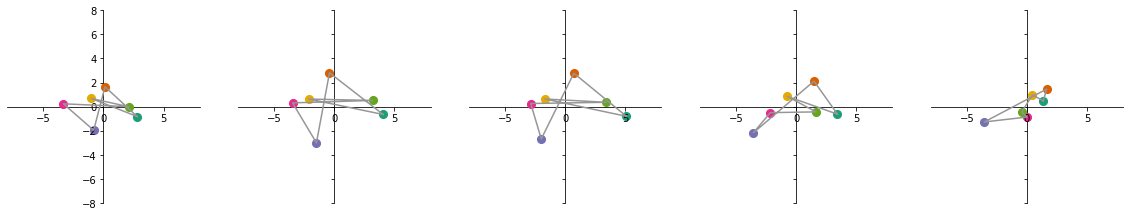

In [ ]:
%cd /content/gdrive/My Drive/data/2b_cont_eegmat
dataset = 'eeg'
ndim = 2
subject_id = 19 #example subject
mode = 'umi'

#find umi/pmi delay window
if mode is 'umi':
  tw = np.arange(70,140) 
elif mode is 'pmi':
  tw = np.arange(247,318)   

# load data from whole trial
ori_wholeTrial = load_data(subject_id+1, tw = None, dataset = dataset) 

# load data from UMI/PMI delay to calculate dPCs
ori_tmp = ori_wholeTrial[:,tw,:] #load EEG data
ori_tmp = center(ori_tmp)

ori_model = dp.dPCA(ori_tmp, n_dim = ndim, old_version=True)
d = ori_model.decoder

X = np.matmul(center(ori_wholeTrial),d) # project data into UMI/PMI subspaces

# plot timecourse of dPC projections of UMI/PMI means
symbol = False #use symbol or color dots
line = True #whether connect dots with lines
axlim = 8
size = 2 #size of datapoint

fig, axs = plt.subplots(1,5, figsize=(5*4, 4*1), sharex=True, sharey=True)

axs[0].set_xlim([-1*axlim,1*axlim])
axs[0].set_ylim([-1*axlim,1*axlim])

# cut data into 5 windows, two halves of n delay, n+1 presentation, and two halves of n+1 delay
xy = X[:,0:70,:].mean(1) 
pf.scatter(xy, axs[0], symbol = symbol, line = line)

xy = X[:,70:140,:].mean(1) 
pf.scatter(xy, axs[1], symbol = symbol, line = line)

xy = X[:,140:165,:].mean(1) 
pf.scatter(xy, axs[2], symbol = symbol, line = line)

xy = X[:,177:247,:].mean(1) 
pf.scatter(xy, axs[3], symbol = symbol, line = line)

xy = X[:,247:318,:].mean(1) 
pf.scatter(xy, axs[4], symbol = symbol, line = line)


# Plot dPCA projection timecourse for example network (RNN)

/content/gdrive/My Drive/data/2Bonly_7units_2tr


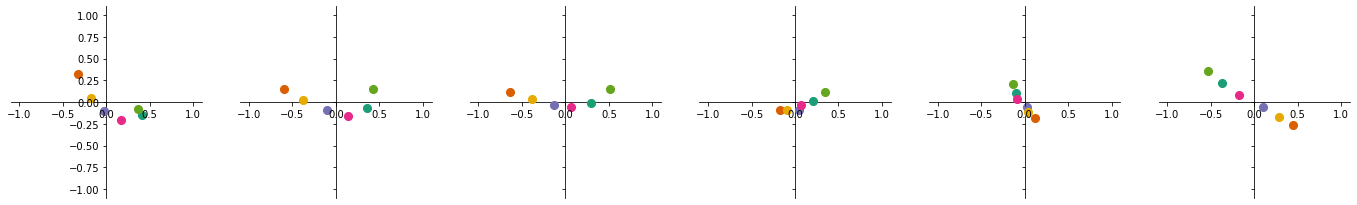

In [ ]:
################################## for RNN  ################################## 
# Load raw data
dataset = 'rnn'
num_unit = 7
ndim = 2
mode = 'umi'

if num_unit == 7:
  %cd /content/gdrive/My Drive/data/2Bonly_7units_2tr
  subject_id = 6 #for 7D, network #7 as example
  axlim = 1.1
  line = False
elif num_unit == 60:
  %cd /content/gdrive/My Drive/data/2Bonly_60units_2tr_circ
  subject_id = 2 #for 60D, network #3 as example
  axlim = 2.25
  line = True

#load two halves of the whole trial where n is umi and pmi
ori_wholeTrial = load_data_rnn(subject_id+1, num_unit = num_unit, dataset = dataset)

# load data from UMI/PMI delay to calculate dPCs
#use second delay timepoint to construct dPC subspace
umi_tmp, pmi_tmp = ori_wholeTrial[:,2,:][:,np.newaxis,:], ori_wholeTrial[:,5,:][:,np.newaxis,:] 

if mode is 'umi':
  umi_tmp = center(umi_tmp)
  ori_model = dp.dPCA(umi_tmp, n_dim = ndim, old_version=True)
elif mode is 'pmi':
  pmi_tmp = center(pmi_tmp)
  ori_model = dp.dPCA(pmi_tmp, n_dim = ndim, old_version=True)
d = ori_model.decoder

# project data into UMI/PMI subspaces
X = np.matmul(center(ori_wholeTrial),d)# 6 x 2

# plot timecourse of dPC projections of UMI/PMI means
symbol = False 

fig, axs = plt.subplots(1,6, figsize=(6*4, 4*1), sharex=True, sharey=True)
axs[0].set_xlim([-1*axlim,1*axlim])
axs[0].set_ylim([-1*axlim,1*axlim])
for i, ax in zip(np.arange(6), axs):
    xy = X[:,i,:]
    pf.scatter(xy, ax, symbol = symbol, line = line)

# Plot timecourse of scalar transform (EEG)

In [ ]:
############################################ cut continuous windows and calculate A - EEG ############################################ 
dataset = 'eeg'
num_sub = 42
ndim = 2
mode = 'umi'

#find umi/pmi delay window
if mode is 'umi':
  tw = np.arange(70,140) 
elif mode is 'pmi':
  tw = np.arange(247,318)   

%cd /content/gdrive/My Drive/data/2b_cont_eegmat

A_eeg = np.zeros((num_sub,318))

for subject_id in range(num_sub):

  ori_wholeTrial = load_data(subject_id+1, tw = None, dataset = dataset) # load whole trial
  
  ori_tmp = center(ori_wholeTrial[:,tw,:])
  ori_model = dp.dPCA(ori_tmp, n_dim = ndim, old_version=True)
  d = ori_model.decoder
  X = np.matmul(center(ori_wholeTrial),d) #dPC projection

  tw_targ = np.arange(0,318) #timepoints for the target of transformation
  tw_start = np.arange(0,70) #time range to anchor start of transformation (first half of first delay)
  Z1 = X[:,tw_start,:] # to transform from
  Z1 = Z1 - Z1.mean(0)

  #loop through all timepoints in whole trial
  for tp in tw_targ:
    Z2 = X[:,tp,:][:,np.newaxis,:] # to transform to
    Z2 = Z2 - Z2.mean(0)
    #calculate scalar
    A_eeg[subject_id, tp] = fit_scale(Z1,Z2)

  print("subject: ", subject_id+1) 

Text(0.5, 1.0, 'scalar transform')

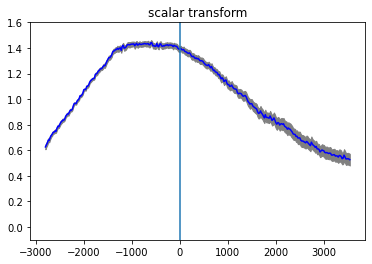

In [ ]:
x = np.arange(-2800,3550,20)

#plot scalar transform
A_avg = np.mean(A_eeg,0)
A_err = stats.sem(A_eeg)
plt.plot(x, A_avg, color = 'b')
plt.axvline(x = 0)
plt.ylim([-0.1,1.6])
plt.fill_between(x, A_avg-A_err, A_avg+A_err,color = 'gray')
plt.title('scalar transform')

# Plot timecourse of scalar transform (RNN)

In [ ]:
############################################ cut continuous windows and calculate A - RNN ############################################ 
dataset = 'rnn'
num_unit = 7
num_sub = 10
ndim = 2
mode = 'umi'

if num_unit == 7:
  %cd /content/gdrive/My Drive/data/2Bonly_7units_2tr
elif num_unit == 60:
  %cd /content/gdrive/My Drive/data/2Bonly_60units_2tr_circ

A_rnn = np.zeros((num_sub,6))

for subject_id in range(num_sub):

  ori_wholeTrial = load_data_rnn(subject_id+1, num_unit = num_unit, tw = None, dataset = dataset) 

  umi_tmp, pmi_tmp = ori_wholeTrial[:,2,:][:,np.newaxis,:], ori_wholeTrial[:,5,:][:,np.newaxis,:]

  if mode is 'umi':
    umi_tmp = center(umi_tmp)
    ori_model = dp.dPCA(umi_tmp, n_dim = ndim, old_version=True)
  elif mode is 'pmi':
    pmi_tmp = center(pmi_tmp)
    ori_model = dp.dPCA(pmi_tmp, n_dim = ndim, old_version=True)
  d = ori_model.decoder

  X = np.matmul(center(ori_wholeTrial),d) #dPC projection
  tw_targ = np.arange(0,6)
  Z1 = X[:,1,:][:,np.newaxis,:] #to transform from first timestep of first delay
  Z1 = Z1 - Z1.mean(0)

  for tp in tw_targ:
    Z2 = X[:,tp,:][:,np.newaxis,:] #to transform to
    Z2 = Z2 - Z2.mean(0)
    A_rnn[subject_id, tp] = fit_scale(Z1, Z2)

  print("subject: ", subject_id+1) 

Text(0.5, 1.0, 'scalar transform')

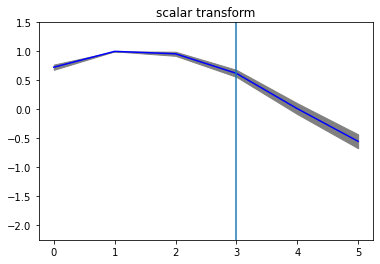

In [ ]:
x = np.arange(0,6)

#plot scaling value 
A_avg = np.mean(A_rnn,0)
A_err = stats.sem(A_rnn)
plt.plot(x, A_avg, color = 'b')
plt.axvline(x = 3)
plt.ylim([-2.25,1.5]) #([-2.75,1.5])
plt.fill_between(x, A_avg-A_err, A_avg+A_err,color = 'gray')
plt.title('scalar transform')